<a href="https://colab.research.google.com/github/juankuntz/LPAE/blob/master/notebooks/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit an LPAE to the MNIST dataset. For more info on the model and training procedure, see [here](https://lpae.readthedocs.io/en/latest/).

**Note**: The notebook runs significantly faster on a GPU (on Colab, select from the top bar Runtime -> 
Change runtime type -> accelerator -> GPU).

# Setup

Are you running this notebook on Colab or locally? In the former case, set the following COLAB parameter to true, in the latter, set it to false and specify the path to the repository.

In [1]:
COLAB = False

In [2]:
import os

# Specify path (the following command does the trick if
# you launched jupyter-lab from the notebook's directory).
REPOSITORY_PATH = os.path.dirname(os.getcwd())

If running on Colab, we need to download the respository:

In [3]:
%%capture

if COLAB:
    # Mount gdrive:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=False) 
    
    # Load the repository:
    import sys
    !rm -rf LPAE
    REPOSITORY_PATH = '/content/lpae'
    !git clone https://github.com/juankuntz/LPAE.git $REPOSITORY_PATH

In either case, we need the following modules:

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Conv2DTranspose, Dense, Reshape, Input, Average
from tensorflow.keras import Sequential, Model
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

2023-04-21 12:18:57.372189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 12:18:57.413176: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 12:18:57.414640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 12:18:58.152535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lastly, we add the repository to the system's path and load the LPAE object:

In [5]:
import sys

# Add repository to system path:
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

# Import the LPAE object:
from src.autoencoders import LPAE

# Model definition and training

**Training data**: Let's fetch $10,000$ MNIST images to train our model with (we also fetch another $1000$ for testing):

In [6]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x, y = tf.constant(x[:10000].astype('float32')[..., np.newaxis]), y[:10000]
x_test, y_test = tf.constant(x_test[:1000].astype('float32')[..., np.newaxis]), y_test[:1000]
data = tf.data.Dataset.from_tensor_slices(x)

Let's check that these are what we expect:

In [7]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None) -> None:
    """
    Plots batch of images.

    Parameters
    ----------
    image_batch: tf.Tensor with dimensions (batch_size, 28, 28, 1)
        Batch of images.
    names: list[str] or None
        Corresponding list of names.
    """
    images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
    if not names:
        names = ['' for _ in images]
    grid_size = math.ceil(len(images) ** (1/2))
    for i, (image, name) in enumerate(zip(images, names)):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.set_title(name)
        plt.imshow(255 - image.astype("uint8"), cmap='Greys')
        plt.axis("off")
    plt.gcf().tight_layout()    
    plt.show()

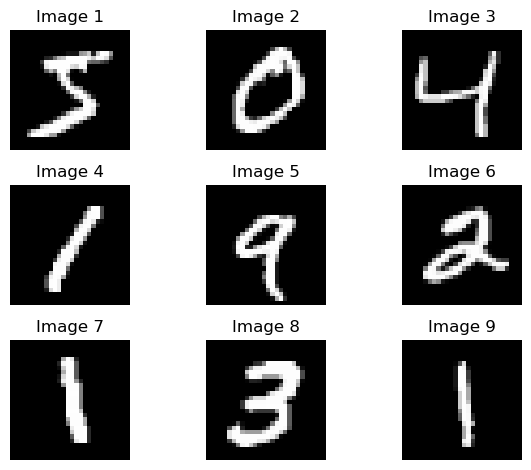

In [8]:
# Plot first nine images:
plot_images(x[:9], [f'Image {i+1}' for i in range(9)])

**Model definition**: To define the model, we need to choose the latent space's dimension and then define a decoder mapping from this space to the data space ($\mathbb{R}^{28\times28}$ as we are dealing with $28\times 28$ greyscale images). Let's try $2$ for the dimension and the simple convolutional decoder used in [this keras VAE tutorial](https://keras.io/examples/generative/vae/):

                    Decoder with 159169 parameters


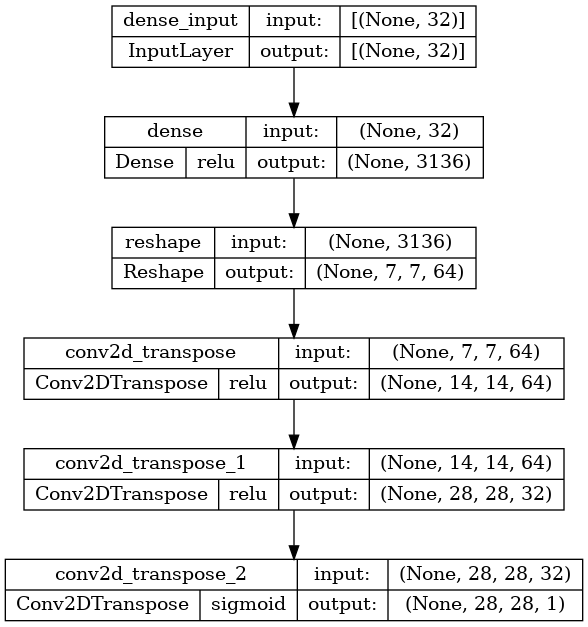

In [9]:
latent_dimensions = 32  
decoder = Sequential([Dense(7 * 7 * 64, activation="relu",
                             input_shape=(latent_dimensions,)),
                       Reshape((7, 7, 64)),
                       Conv2DTranspose(64, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(32, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(1, 3, activation="sigmoid",
                                       padding="same")
                       ], name='decoder')

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in decoder.trainable_variables])
print(f'                    Decoder with {n_parameters} parameters')
print('===================================================================')
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_activations=True)

We can now define the entire model:

In [10]:
model = LPAE(latent_dimensions=latent_dimensions, decoder=decoder, observation_noise_std=1e-2)

**Training**: Training entails optimizing over the parameters $\theta$ of the decoder. To do so, we use:
- $10$ particles,
- a learning rate of $0.0005$ for the latent variable updates,
- and an RMSProp optimizer for the decoders parameter updates.

The decoder's final layer uses a sigmoid activation function, and, so, maps to $[0,1]^{28\times28}$. Hence, we ought to normalize the images so that the lie in $[0,1]^{28\times28}$. We can get the model to handle this internally for us by feeding it to appropiate  `preprocessor` and `postprocessor` layers (the former normalizes, the latter unnormalizes, and both must be [keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)). We have all we need to configure the training:

In [11]:
n_particles = 10
model.compile(lv_learning_rate=5e-4, n_particles=n_particles,
              optimizer=tf.keras.optimizers.RMSprop(),
              preprocessor=tf.keras.layers.Rescaling(scale=1./255),
              postprocessor=tf.keras.layers.Rescaling(scale=255.))

We can now train the model by calling its fit method, passing in the data, the number of epochs we want it to train for, and the batch size we'd like it to use:

In [12]:
model.fit(data=data, epochs=100, batch_size=256)  

## Saving and loading the model

It's easy to save the fitted model so we don't have to re-train it every time we run this notebook:

In [13]:
if COLAB:
    # Set save directory in Google drive so that it's persistent across notebook re-starts:
    CHECKPOINT_PATH = 'gdrive/MyDrivec/lpae_ckpts/checkpoint_0/'
else:
    CHECKPOINT_PATH = REPOSITORY_PATH + '/ckpts/checkpoint_0/'
model.save(CHECKPOINT_PATH)

To load it, use the from_save constructor method:

In [14]:
del model
model = LPAE.from_save(CHECKPOINT_PATH)

# Inference

We've fitted the model to the dataset, so what can we do with it? Before answering that question, let's first get a bit more of a feel for how the model works. 

## Visualizing the posterior approximation

As discussed in the [docs](https://lpae.readthedocs.io/en/latest/) (in what follows, we use the notation introduced there), the model assumes that each image $y^m$ in our training set was generated by mapping a vector of latent variables $x^m$ to the image space via the decoder $f_{\theta_K}:\mathbb{R}^{32}\to\mathbb{R}^{28\times28}$ (and adding a bit of Gaussian noise). It doesn't pressume to know what $x^m$ is and instead offers $N:=10$ guesses it deems equally as likely: $X^{1,m}_K,\dots, X^{N,m}_K$ which we refer to as 'particles'. We can visualize by plotting them their coordinates one at a time:

                                 Particles for image 0.


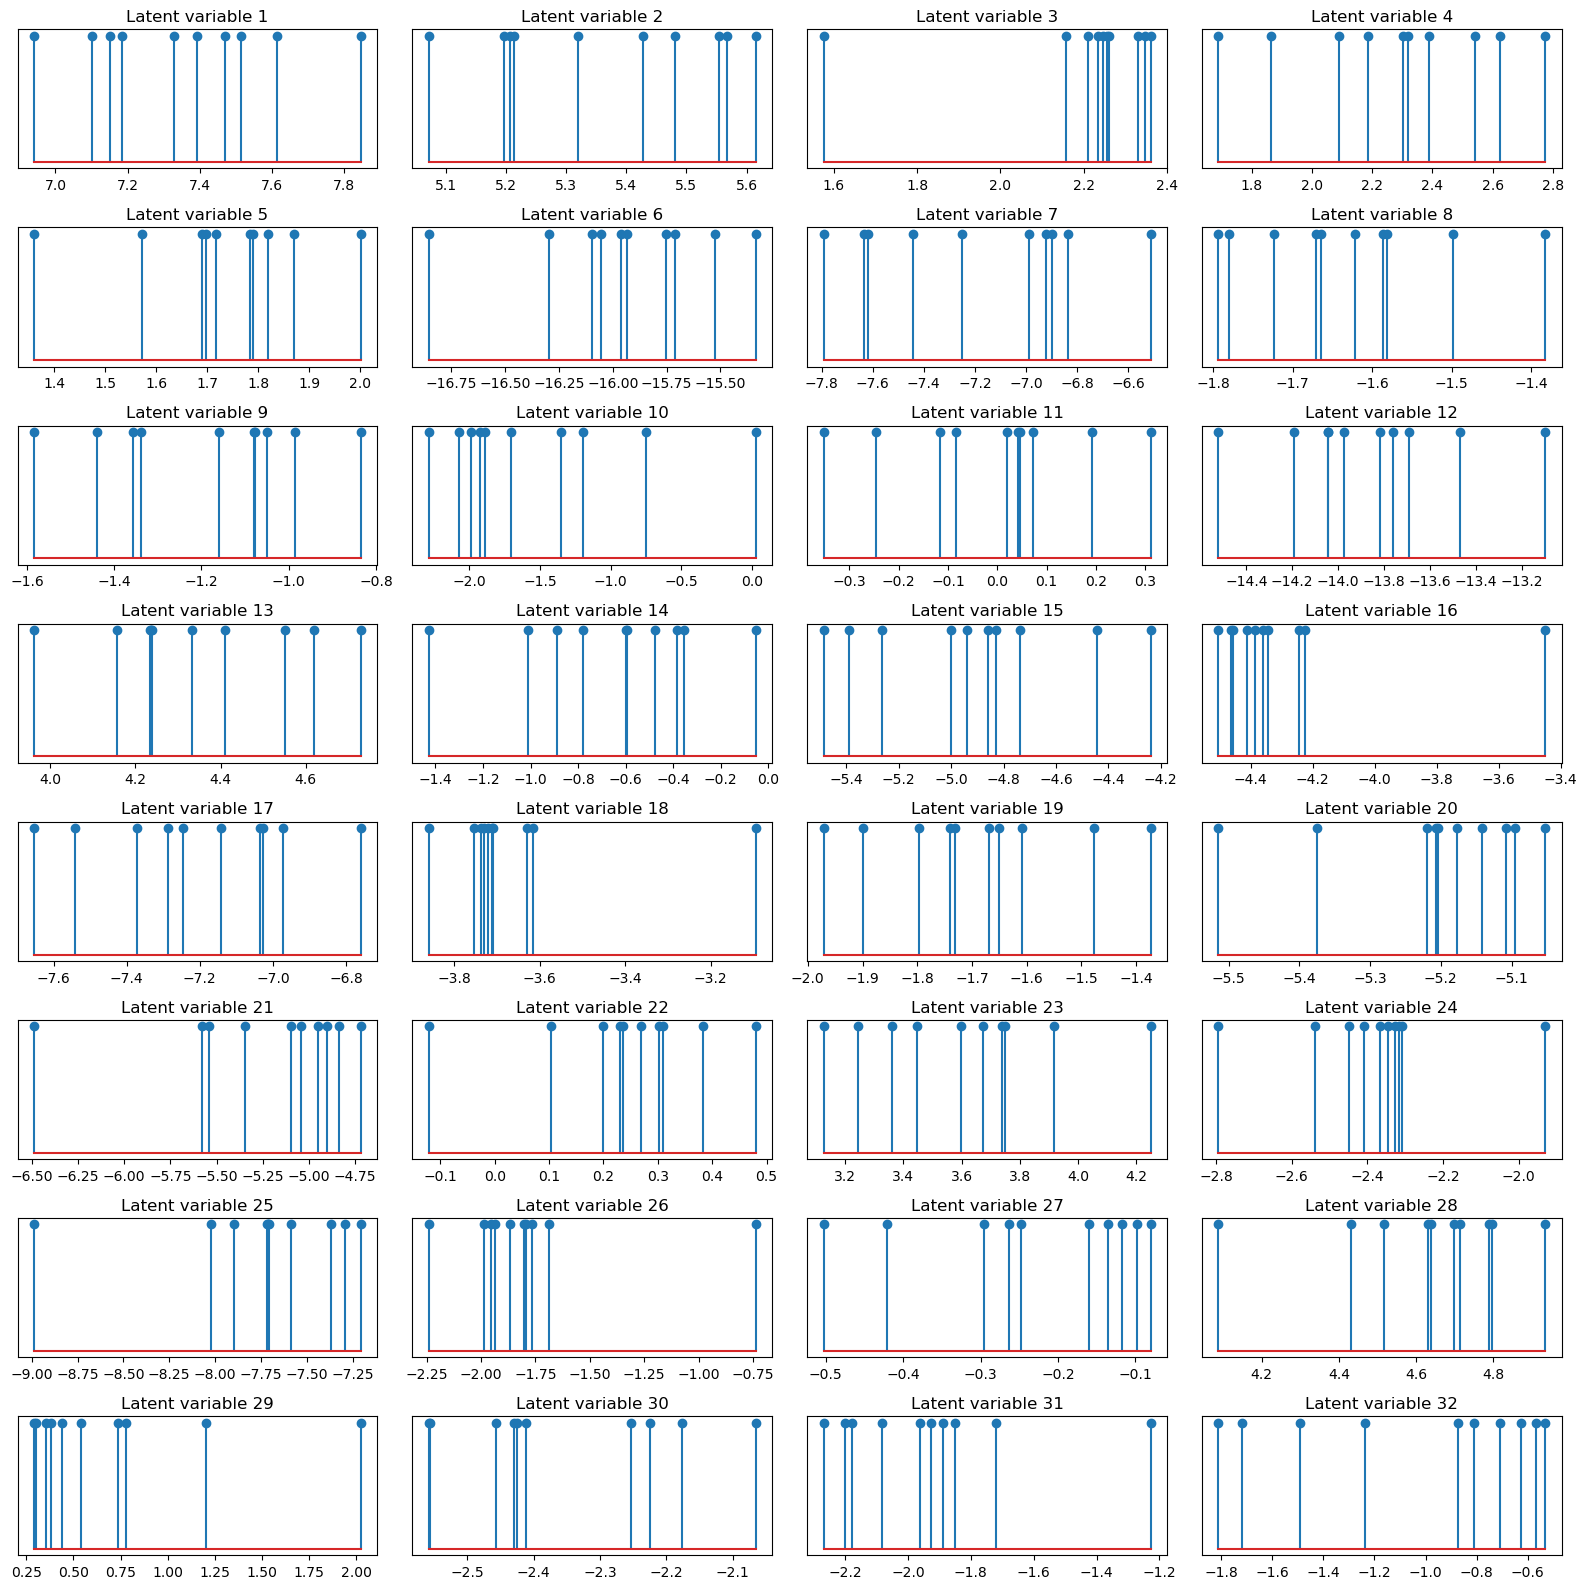

In [15]:
i = 0

# Get particles for the ith image:
particles = model.get_particles(index_batch=[i])[0, :, :]

# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    plt.stem(particles[:, j].numpy(), np.ones(10))
plt.gcf().tight_layout()   
print(f'                                 Particles for image {i}.')
print('==================================================================================')
plt.show()

Equivalently, we can think of the model returning, for each image $y^m$, a distribution over the possible values of $x^m$ defined by the empirical distribution of these particles: $N^{-1}\sum_{n=1}^N\delta_{X_K^{n,m}}$. We can visualize this distribution by examining it's marginals (and with the help of a KDE):

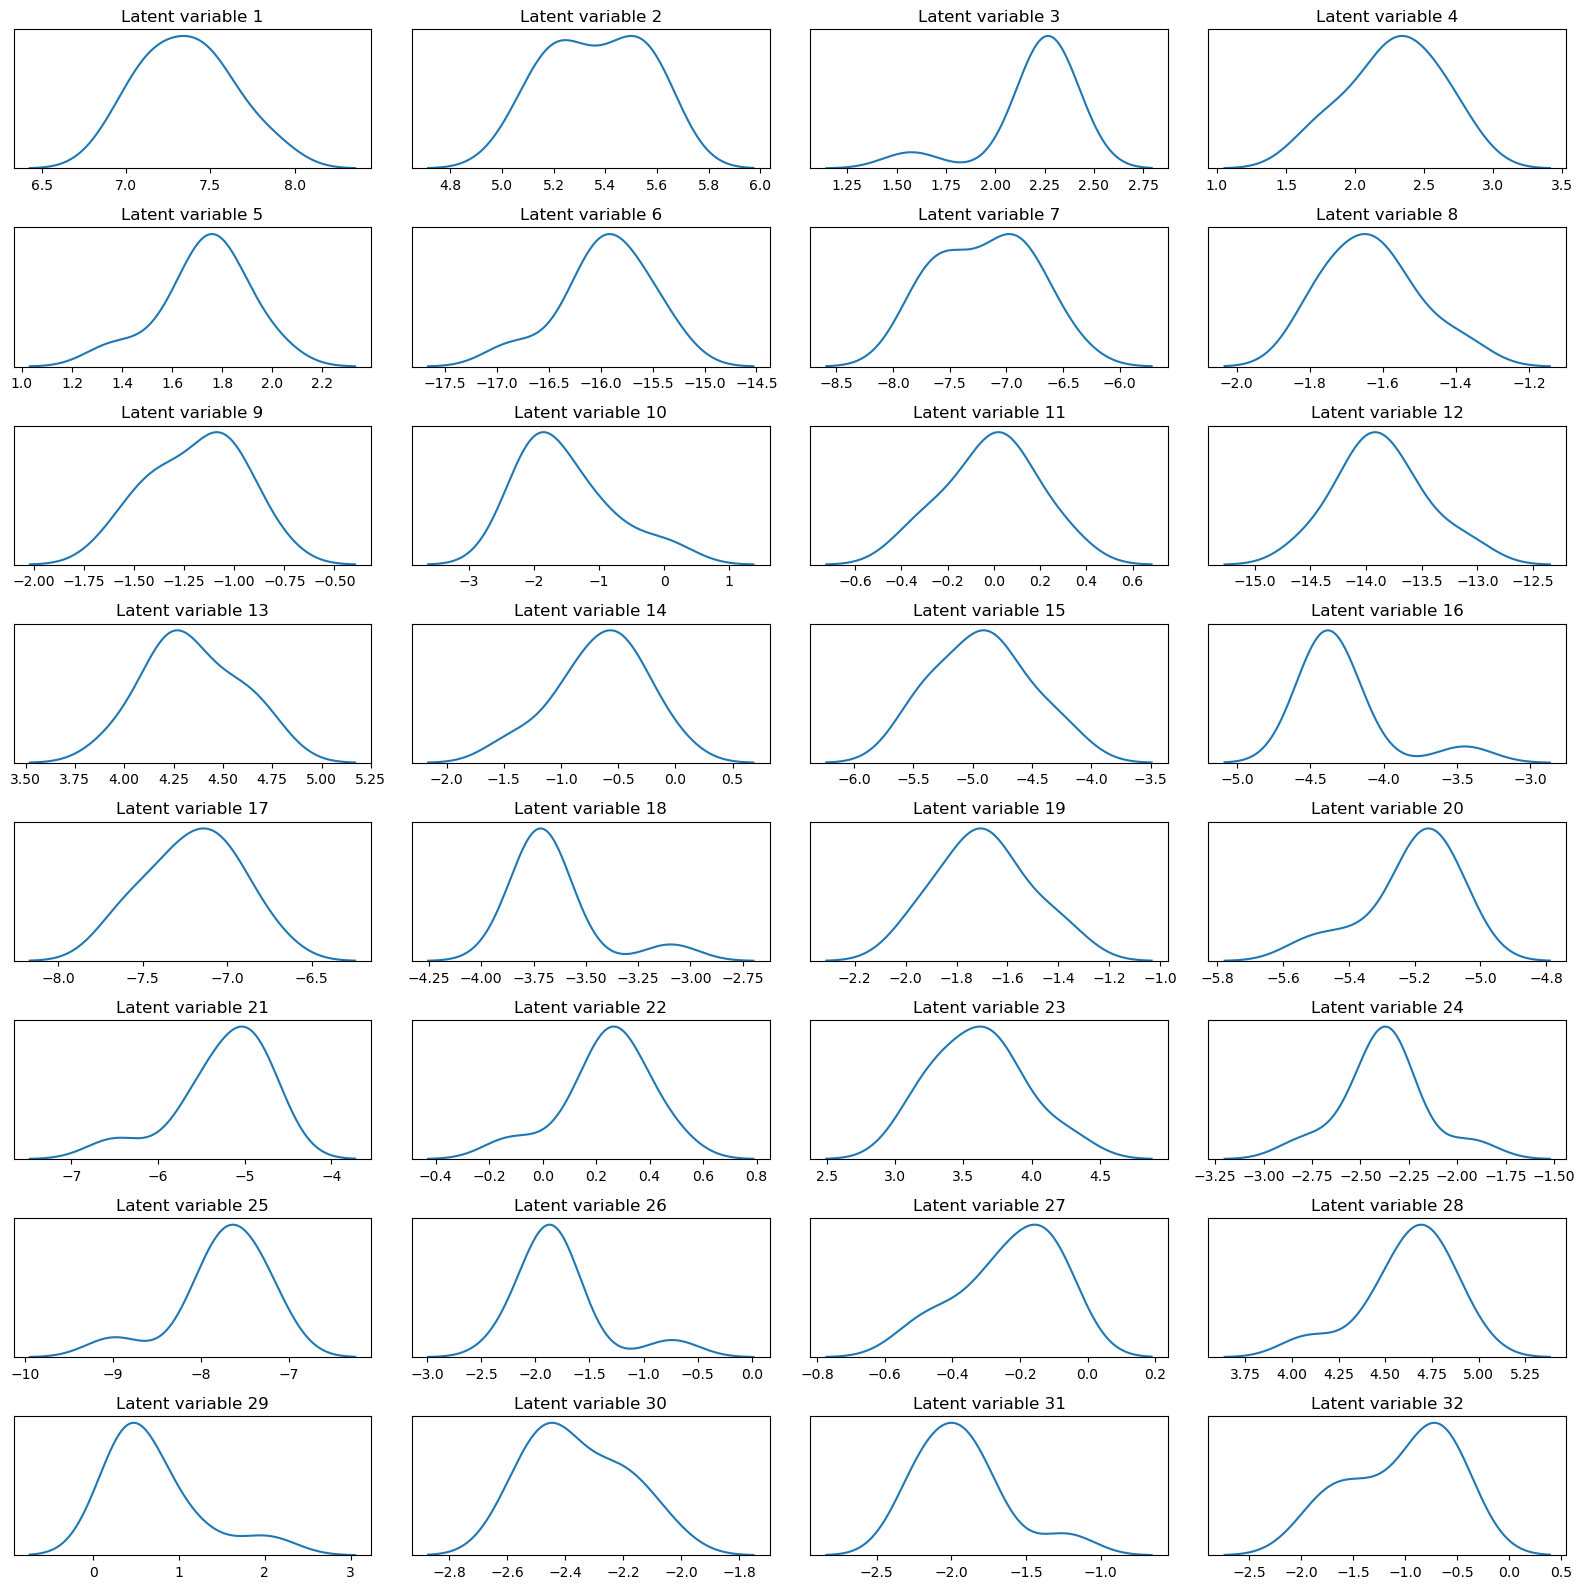

In [16]:
# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    sns.kdeplot(particles[:, j].numpy(), ax=ax)
plt.gcf().tight_layout()    
plt.show()

We refer to this distribution as an 'approximate posterior' because it approximates 

$$p_{\theta_K}(x^m|y^m)=\frac{p_{\theta_K}(x^m,y^m)}{p_{\theta_K}(y^m)}.$$

While the distribution doesn't look particularly peaked, it's pushforward through the decoder is actually very peaked around the training image $y^m$. In other words, mapping any of the particles through the decoder we get an image almost indistinguishable from $y^m$:

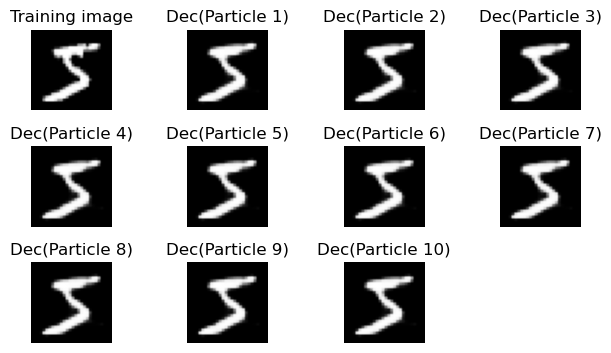

In [76]:
decoded_particles = model.decode_particles(index_batch=[i])
names = ['Training image'] + [f'Dec(Particle {j+1})' 
                              for j in range(n_particles)]
plot_images(tf.concat([x[i][tf.newaxis, ...], decoded_particles], axis=0), names)

## Image representations 

In short, the model learns representations of MNIST images: the representation of the $m^{th}$ image being the corresponding set of particles $\{X^{1,m}_K,\dots, X_K^{N,m}\}$. Or, equivalently, the particles' empirical distribution $N^{-1}\sum_{n=1}^N\delta_{X_K^{n,m}}$ or 'approximate posterior'.

To visualize all of these representations, we can plot (the first $4$ princicple components of) all the particles. If we color each of these by the corresponding's image label we see that they, at least partially, cluster by label:

<a id='visualize_particles'></a>

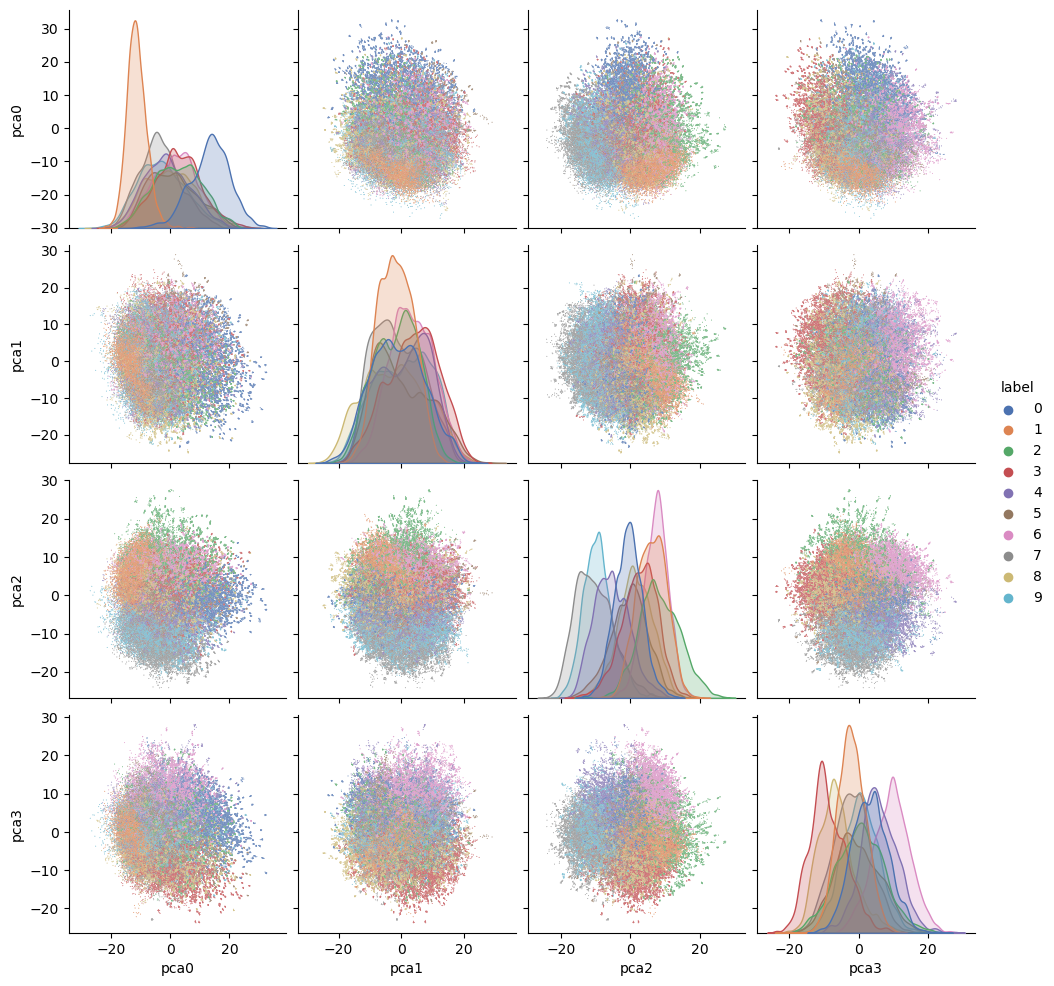

In [18]:
particles = pd.DataFrame(model.flatten_particles(model.get_particles()).numpy(),
                         columns=[f'Latent variable {i}' for i in range(latent_dimensions)])
particles_pca = PCA(n_components=4).set_output(transform='pandas').fit_transform(particles)
particles_pca['label'] = np.repeat(y, n_particles)
sns.pairplot(particles_pca, hue='label', palette='deep', plot_kws={'s': 0.5})

In particular, we can train a classifier on these representations to predict the image's label. However, for this simple dataset, a naive classifier trained on the raw image data does quite well and we don't gain anything by training it on the representations (in fact, we lose some, see the end of the notebook).

## Interpolating images in a semantically meaningful way

These representations, however, let us do certain things we'd struggle to do with the original data. For instance, if linearly interpolate between two images, we just get a series of intermediate images were the first image fades out and the second fades in:

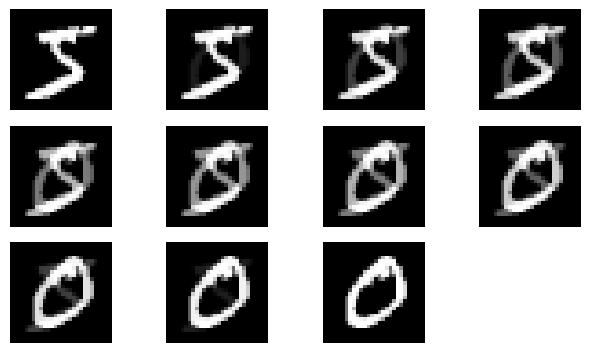

In [74]:
i, j = 0, 1
plot_images(tf.stack([(1 - t) * x[i] + t * x[j] for t in np.linspace(0, 1, 11)]))

On the other hand, if for each image, we pick a particle, linearly interpolate between the two particles, and map the intermediate particles through the decoder, we get a semantically meaningful interpolation between to two images:

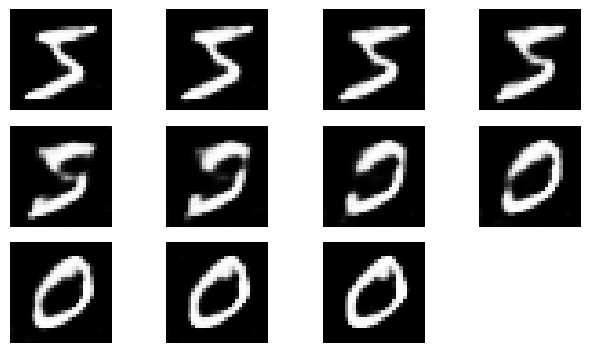

In [75]:
particle_i = model.get_particles((i,), 1)[0, ...]
particle_j = model.get_particles((j,), 1)[0, ...]
plot_images(model.decode(tf.concat([(1 - t) * particle_i + t * particle_j  for t in np.linspace(0, 1, 11)], axis=0)))

## Generating fakes

Similarly, if we fit a mixture of Gaussians to the collection of all particles visualized [above](#visualize_particles), draw latent variables from this mixture, and push them through the decoder, we get 'fakes' that look like the images in our training set:

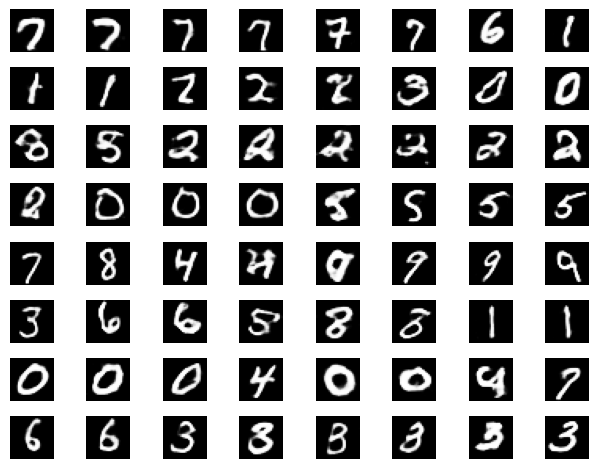

In [89]:
n_fakes = 64
fakes = model.generate_fakes(n_fakes=n_fakes)
plot_images(fakes)

While some of these digits look like they were produced by someone with handwritting even worse than mine, they're still a lot better than what we get by sampling a mixture of Gaussian directly fit on the image data: 

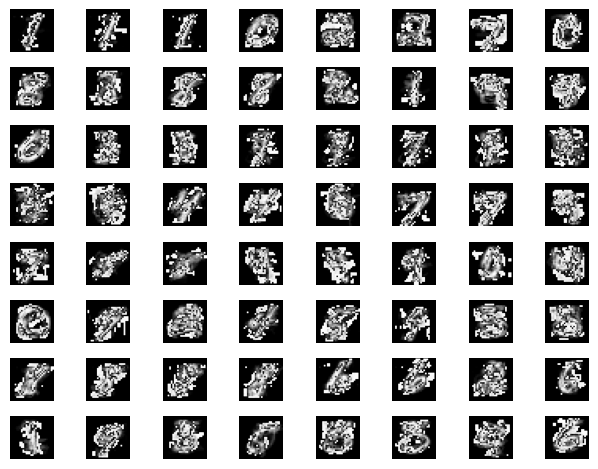

In [92]:
gmm_raw_data = GaussianMixture(n_components=100).fit(tf.reshape(x, [x.shape[0], x.shape[1] * x.shape[2]]).numpy())
fakes_from_raw, _ = gmm_raw_data.sample(n_samples=n_fakes)
plot_images(tf.reshape(fakes_from_raw, [n_fakes, 28, 28, 1]))

## What about images not in our training set?

I've been avoiding a question: where did these particles come from? They are a by-product of the training procedure (see [here](https://lpae.readthedocs.io/en/latest/)) which requires $N$ of them per image in our training set. So what about images not in our training set? How do we get such particles and representations for them?

## Recovering images corrupted with noise

In [21]:
#@title Definition of corrupt()

def corrupt(images: tf.Tensor, noise_intensity: float = 0.3):
    images += noise_intensity * 255 * tf.random.normal(shape=images.shape)
    images *= 1 + noise_intensity * (tf.random.uniform(shape=images.shape) - 0.5)
    return tf.minimum(tf.maximum(images, 0), 255)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


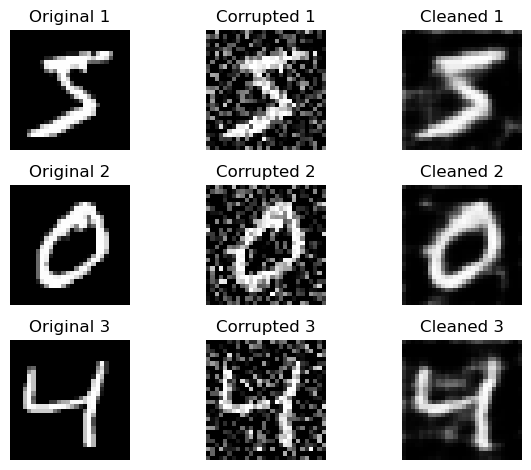

In [22]:
n_images = 3
images = x[:n_images, ...]
corrupted = corrupt(images)
reconstructed = model(corrupted, n_steps=1000)
names = sum([[f'Original {i + 1}', f'Corrupted {i + 1}', f'Cleaned {i + 1}']
             for i in range(n_images)], [])
interweaved = tf.reshape(tf.stack([images, corrupted, reconstructed], axis=1),
                         (3 * n_images,) + images.shape[1:])
plot_images(interweaved, names)

## Classifying the images

In [24]:
# On representations:
# clf = tf.keras.Sequential([
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

# clf.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])
# clf.fit(model.flatten_particles(model.get_particles()).numpy(), np.repeat(y, n_particles), epochs=10, validation_split=0.2)

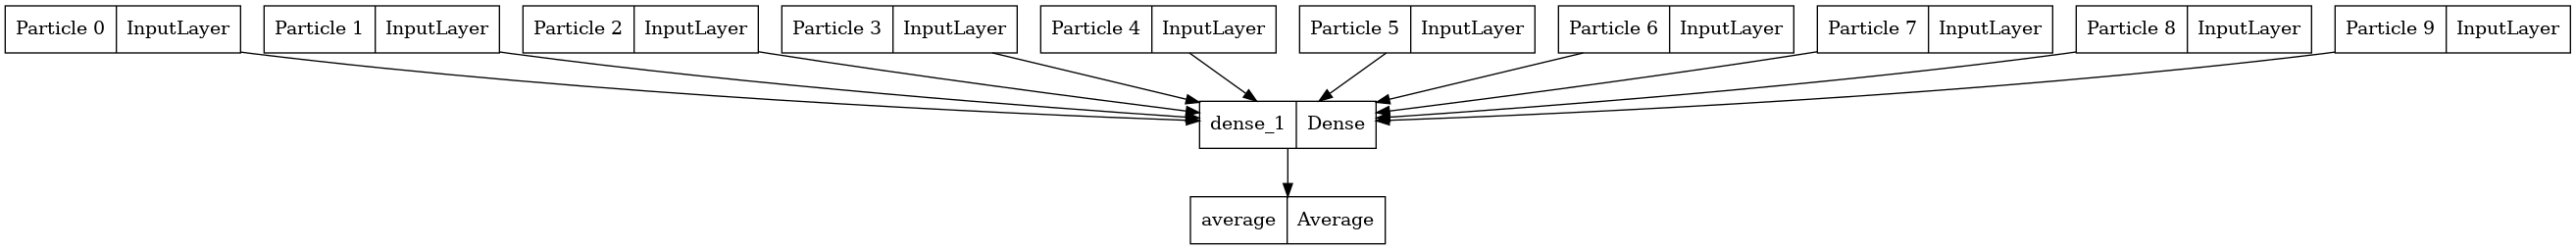

In [25]:
inputs = [Input(shape=(latent_dimensions,), name=f'Particle {i + 1}') for i in range(n_particles)]
fully_connected = Dense(10, input_shape=(latent_dimensions,), activation='softmax')
h = [fully_connected(particle) for particle in inputs]
output = Average()(h)
clf = Model(inputs=inputs, outputs=output)
tf.keras.utils.plot_model(clf)

In [26]:
particles = model.get_particles()
clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
clf.fit([particles[:, i, :] for i in range(n_particles)], y, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 4.5061 - accuracy: 0.3099 - val_loss: 2.1903 - val_accuracy: 0.5325
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 1.4614 - accuracy: 0.6503 - val_loss: 1.1013 - val_accuracy: 0.7200
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.8334 - accuracy: 0.7775 - val_loss: 0.7856 - val_accuracy: 0.7960
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.8328 - val_loss: 0.6471 - val_accuracy: 0.8240
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.8580 - val_loss: 0.5817 - val_accuracy: 0.8430
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.8748 - val_loss: 0.5464 - val_accuracy: 0.8515
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8817 - val_loss: 0.5231 - val_accuracy: 0.8545
Epoch 

In [27]:
# On raw images:
clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Dense(10)
])
clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
clf.fit(x, y, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.9837 - accuracy: 0.7644 - val_loss: 0.5952 - val_accuracy: 0.8615
Epoch 2/10
250/250 [==============================] - 0s 1ms/step - loss: 0.4776 - accuracy: 0.8831 - val_loss: 0.4645 - val_accuracy: 0.8815
Epoch 3/10
250/250 [==============================] - 0s 1ms/step - loss: 0.3859 - accuracy: 0.8999 - val_loss: 0.4212 - val_accuracy: 0.8880
Epoch 4/10
250/250 [==============================] - 0s 1ms/step - loss: 0.3422 - accuracy: 0.9110 - val_loss: 0.3956 - val_accuracy: 0.8915
Epoch 5/10
250/250 [==============================] - 0s 1ms/step - loss: 0.3143 - accuracy: 0.9178 - val_loss: 0.3785 - val_accuracy: 0.8955
Epoch 6/10
250/250 [==============================] - 0s 1ms/step - loss: 0.2937 - accuracy: 0.9219 - val_loss: 0.3712 - val_accuracy: 0.8980
Epoch 7/10
250/250 [==============================] - 0s 1ms/step - loss: 0.2794 - accuracy: 0.9241 - val_loss: 0.3631 - val_accuracy: 0.9010
Epoch 